In [1]:
from pathlib import Path
from aicsimageio import AICSImage
import dask
from dask.distributed import LocalCluster, Client
import dask.array as da
import time
import skimage.io as ski

import pyclesperanto_prototype as cle
import napari
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\daov1\AppData\Local\anaconda3\envs\devbio-napari-env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import numpy as np
import pandas as pd

In [3]:
def aics_file(file_path):
    data = AICSImage(file_path)
    image = data.get_image_data('ZYX', C=0, T=0)
    return image

# initialise by lazily loaded and accessed as needed
def aics_file_5d(file_path):
    data = AICSImage(file_path)
    return data

# load aicsimage into numpy array
def get_image(aicsimage):
    image = aicsimage.get_image_data('ZYX', C=0, T=0)
    return image

def read_file(file_path):
    image = ski.imread(file_path)
    return image

In [4]:
folder_path = Path.cwd()
file_pattern = 'Data/20191104_ABAT029_REG1-CTRL_DAPI_CD31-ENDOM-680_Th-647_hCD45-33-488_aSMA-CY3_aGFP-594.ome.btf'
filenames = []

for file in folder_path.glob(file_pattern):
    filenames = np.append(filenames, file)
filenames = sorted(filenames)

filenames

['20191104_ABAT029_REG1-CTRL_DAPI_CD31-ENDOM-680_Th-647_hCD45-33-488_aSMA-CY3_aGFP-594.ome.btf']

In [ ]:
%%timeit
aics_image = aics_file(filenames[0])

In [7]:
%%timeit -r 10 -n 10
aics_image_5d = AICSImage(filenames[0])

6.6 ms ± 336 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [22]:
%%timeit
skimage_image = read_file(filenames[0])

34.2 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Measuring interactivity - timeseries

In [6]:
# dataframe management
def process_time(df):
    df = pd.read_csv(df, header=None, names=['time'])
    df.index.rename('timepoint', inplace=True)
    return df
    
def correct_mean_and_df(df):
    df = df.iloc[1:]
    average = df.mean()
    avg = average[0]
    return avg, df

plt.rcParams['font.size'] = '14'

In [5]:
dask3d_df = process_time('csv/t_3d_loading.csv')
dask2d_df = process_time('csv/t_2d_loading.csv')
ram_df = process_time('csv/t_ram_loading.csv')
dask3d_df.head()

,time
timepoint,
0,0.000066
1,45.053280
2,41.426304
3,39.375548
4,40.950364


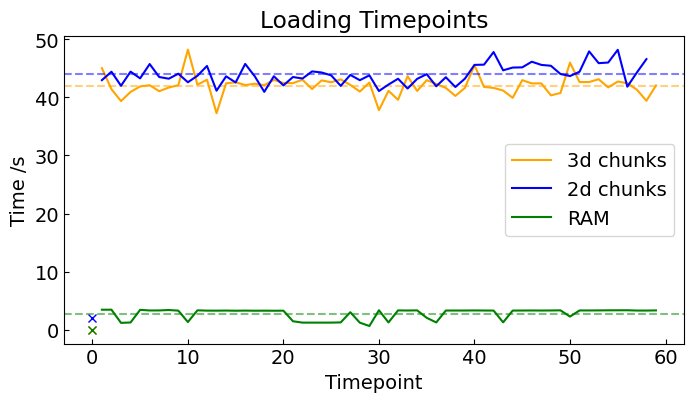

In [7]:
avg1, dask3d_df_corrected = correct_mean_and_df(dask3d_df)
avg2, dask2d_df_corrected = correct_mean_and_df(dask2d_df)
avg3, ram_df_corrected = correct_mean_and_df(ram_df)

dfs = [[dask3d_df, dask3d_df_corrected, avg1, '3d chunks', 'orange'],
       [dask2d_df, dask2d_df_corrected, avg2, '2d chunks', 'b'],
       [ram_df, ram_df_corrected, avg3, 'RAM', 'g']]

    
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
       
for df, df_corrected, avg, label, color in dfs:
    ax.plot(df_corrected['time'], label=label, color=color)
    ax.axhline(avg, alpha=0.5, linestyle='--', color=color)
    
    ax.plot(0, df.iloc[0], color=color, linestyle='none', marker='x')
    
plt.title('Loading Timepoints') 
plt.xlabel('Timepoint')
plt.ylabel('Time /s')
ax.legend()
ax.tick_params(direction='in')

### Measuring interactivity - z slices

In [8]:
# dataframe management
def process_zslice(df):
    df = pd.read_csv(df, header=None, names=['time'])
    df.index.rename('z-slice', inplace=True)
    return df

In [9]:
z_2d_dask_df = process_zslice('csv/z_2d_loading.csv')
z_3d_dask_df = process_zslice('csv/z_3d_loading.csv')
z_ram_df = process_zslice('csv/z_ram_loading.csv')
z_2d_dask_df.head()

,time
z-slice,
0,0.057967
1,0.063329
2,0.059995
3,0.060536
4,0.060770


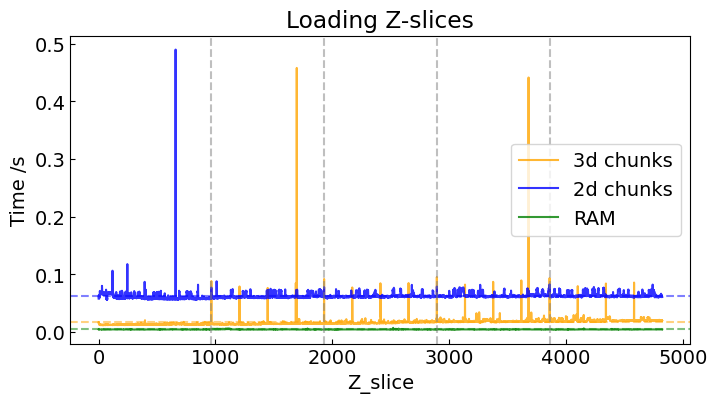

In [12]:
avg1 = z_2d_dask_df.mean()[0]
avg2 = z_3d_dask_df.mean()[0]
avg3 = z_ram_df.mean()[0]


dfs = [
       [z_3d_dask_df, avg2, '3d chunks', 'orange'],
       [z_2d_dask_df, avg1, '2d chunks', 'b'],
       [z_ram_df, avg3, 'RAM', 'g']
      ]

    
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
       
for df, avg, label, color in dfs:
    ax.plot(df['time'], label=label, color=color, alpha=0.8)
    ax.axhline(avg, alpha=0.5, linestyle='--', color=color)

for i in np.arange(1,5):
    ax.axvline(965*i, alpha=0.5, linestyle='--', color='gray')

# plt.yscale('log')        
        
plt.title('Loading Z-slices') 
plt.xlabel('Z_slice')
plt.ylabel('Time /s')
ax.legend()
ax.tick_params(direction='in')